PyTorch Geometric Installing for Colab

In [1]:
!pip install -q torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1
!pip install -q torch-scatter torch-sparse torch-cluster torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

ERROR: Could not find a version that satisfies the requirement torch==2.0.0 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0)
ERROR: No matching distribution found for torch==2.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.0 MB/s eta 0:00:00


Importing Required libraries

In [28]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import NeighborSampler
from torch_geometric.nn import SAGEConv
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Layer, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, recall_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential


Uploading dataset

In [3]:
import gdown


file_id = "1FhRfojbTy6j8YKSRGwyArKjUzjGVsaXj"
url = f"https://drive.google.com/uc?id={file_id}"

output = "telecom_churn_dataset.csv"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1FhRfojbTy6j8YKSRGwyArKjUzjGVsaXj
To: /content/telecom_churn_dataset.csv
100%|██████████| 79.2M/79.2M [00:00<00:00, 133MB/s]


'telecom_churn_dataset.csv'

Data Preprocessing

In [7]:
dataframe = pd.read_csv("telecom_churn_dataset.csv")
dataframe.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [8]:
variables_needed = [
    'mobile_number', 'circle_id', 'arpu_6', 'arpu_7', 'arpu_8', 'arpu_9',
    'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9',
    'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9',
    'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'total_og_mou_9',
    'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_ic_mou_9',
    'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9',
    'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9',
    'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9',
    'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'last_day_rch_amt_9',
    'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
    'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
    'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',
    'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_2g_mb_9',
    'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'vol_3g_mb_9',
    'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9',
    'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9',
    'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'night_pck_user_9',
    'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'monthly_2g_9',
    'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_2g_9',
    'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'monthly_3g_9',
    'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'sachet_3g_9',
    'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
    'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'
]

dataframe = dataframe[variables_needed]

dataframe.head()


,mobile_number,circle_id,arpu_6,arpu_7,arpu_8,arpu_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,34.047,355.074,268.321,86.285,0.0,0.00,0.00,0.00,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,167.690,189.058,210.226,290.714,0.0,0.00,0.00,38.49,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,221.338,251.102,508.054,389.500,0.0,54.86,44.38,0.00,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,261.636,309.876,238.174,163.426,0.0,0.00,0.00,0.00,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [9]:
missing_values = dataframe.isnull().sum()
missing_percentage = (missing_values / len(dataframe)) * 100

missing_data = pd.DataFrame({
    'Missing_values': missing_values,
    'Missing_Percentage': missing_percentage
}).sort_values(by='Missing_Percentage', ascending=False)

missing_data[missing_data['Missing_values'] > 0]

,Missing_values,Missing_Percentage
fb_user_6,74846,74.846748
night_pck_user_6,74846,74.846748
arpu_3g_6,74846,74.846748
arpu_2g_6,74846,74.846748
av_rech_amt_data_6,74846,74.846748
max_rech_data_6,74846,74.846748
total_rech_data_6,74846,74.846748
av_rech_amt_data_7,74428,74.428744
total_rech_data_7,74428,74.428744
max_rech_data_7,74428,74.428744


In [10]:
fill_with_zero = [col for col in dataframe.columns if col.startswith(('fb_user_', 'night_pck_user_'))]
dataframe[fill_with_zero] = dataframe[fill_with_zero].fillna(0)
fill_with_median = [col for col in dataframe.columns if col.startswith((
    'arpu_2g_', 'arpu_3g_', 'max_rech_data_', 'av_rech_amt_data_', 'total_rech_data_'))]
dataframe[fill_with_median] = dataframe[fill_with_median].fillna(dataframe[fill_with_median].median())

In [11]:
roaming_columns = [col for col in dataframe.columns if col.startswith(('roam_ic_mou_', 'roam_og_mou_'))]
dataframe[roaming_columns] = dataframe[roaming_columns].fillna(0)

In [12]:
dataframe.head(15)

,mobile_number,circle_id,arpu_6,arpu_7,arpu_8,arpu_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,197.385,214.816,213.803,21.100,0.00,0.00,0.00,0.00,...,0,1.0,1.0,1.0,0.0,968,30.40,0.00,101.20,3.58
1,7001865778,109,34.047,355.074,268.321,86.285,0.00,0.00,0.00,0.00,...,0,0.0,1.0,1.0,0.0,1006,0.00,0.00,0.00,0.00
2,7001625959,109,167.690,189.058,210.226,290.714,0.00,0.00,0.00,38.49,...,0,0.0,0.0,0.0,1.0,1103,0.00,0.00,4.17,0.00
3,7001204172,109,221.338,251.102,508.054,389.500,0.00,54.86,44.38,0.00,...,0,0.0,0.0,0.0,0.0,2491,0.00,0.00,0.00,0.00
4,7000142493,109,261.636,309.876,238.174,163.426,0.00,0.00,0.00,0.00,...,0,0.0,0.0,0.0,0.0,1526,0.00,0.00,0.00,0.00
5,7000286308,109,50.258,58.810,83.386,170.826,0.00,0.00,0.00,0.00,...,0,0.0,0.0,0.0,0.0,1471,0.00,0.00,0.00,0.00
6,7001051193,109,429.023,190.704,255.114,114.751,0.00,0.00,0.00,0.00,...,0,0.0,0.0,0.0,0.0,1673,0.00,0.00,0.00,0.00
7,7000701601,109,1069.180,1349.850,3171.480,500.000,16.23,33.49,31.64,0.00,...,0,0.0,0.0,0.0,0.0,802,57.74,19.38,18.74,0.00
8,7001524846,109,378.721,492.223,137.362,166.787,0.00,0.00,0.00,0.00,...,0,0.0,1.0,1.0,0.0,315,21.03,910.65,122.16,0.00
9,7001864400,109,119.518,247.435,170.231,160.042,0.00,0.00,0.00,0.00,...,0,0.0,1.0,0.0,0.0,902,0.00,0.00,0.00,0.00


In [13]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
mobile_number,99999.0,7.001207e+09,695669.386290,7.000000e+09,7.000606e+09,7.001205e+09,7.001812e+09,7.002411e+09
circle_id,99999.0,1.090000e+02,0.000000,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02
arpu_6,99999.0,2.829874e+02,328.439770,-2.258709e+03,9.341150e+01,1.977040e+02,3.710600e+02,2.773109e+04
arpu_7,99999.0,2.785366e+02,338.156291,-2.014045e+03,8.698050e+01,1.916400e+02,3.653445e+02,3.514583e+04
arpu_8,99999.0,2.791547e+02,344.474791,-9.458080e+02,8.412600e+01,1.920800e+02,3.693705e+02,3.354362e+04
...,...,...,...,...,...,...,...,...
aon,99999.0,1.219855e+03,954.733842,1.800000e+02,4.670000e+02,8.630000e+02,1.807500e+03,4.337000e+03
aug_vbc_3g,99999.0,6.817025e+01,267.580450,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.291622e+04
jul_vbc_3g,99999.0,6.683906e+01,271.201856,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.165600e+03
jun_vbc_3g,99999.0,6.002120e+01,253.938223,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.116621e+04


In [14]:
negative_arpu = dataframe[(dataframe['arpu_6'] < 0) | (dataframe['arpu_7'] < 0) | (dataframe['arpu_8'] < 0) | (dataframe['arpu_9'] < 0)]
print(f"Data with negative ARPU Rows: {len(negative_arpu)}")

Data with negative ARPU Rows: 2133


In [15]:
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9']
for col in arpu_cols:
    dataframe[col] = dataframe[col].apply(lambda x: 0 if x < 0 else x)

In [16]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
mobile_number,99999.0,7.001207e+09,695669.386290,7.000000e+09,7.000606e+09,7.001205e+09,7.001812e+09,7.002411e+09
circle_id,99999.0,1.090000e+02,0.000000,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02
arpu_6,99999.0,2.830959e+02,328.187736,0.000000e+00,9.341150e+01,1.977040e+02,3.710600e+02,2.773109e+04
arpu_7,99999.0,2.786829e+02,337.881891,0.000000e+00,8.698050e+01,1.916400e+02,3.653445e+02,3.514583e+04
arpu_8,99999.0,2.792119e+02,344.407694,0.000000e+00,8.412600e+01,1.920800e+02,3.693705e+02,3.354362e+04
...,...,...,...,...,...,...,...,...
aon,99999.0,1.219855e+03,954.733842,1.800000e+02,4.670000e+02,8.630000e+02,1.807500e+03,4.337000e+03
aug_vbc_3g,99999.0,6.817025e+01,267.580450,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.291622e+04
jul_vbc_3g,99999.0,6.683906e+01,271.201856,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.165600e+03
jun_vbc_3g,99999.0,6.002120e+01,253.938223,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.116621e+04


/tmp/ipython-input-1890293249.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataframe[col], ax=axs[i//2, i%2], shade=True)
/tmp/ipython-input-1890293249.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataframe[col], ax=axs[i//2, i%2], shade=True)
/tmp/ipython-input-1890293249.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataframe[col], ax=axs[i//2, i%2], shade=True)
/tmp/ipython-input-1890293249.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataframe[col], ax=axs[i//2, i%2], 

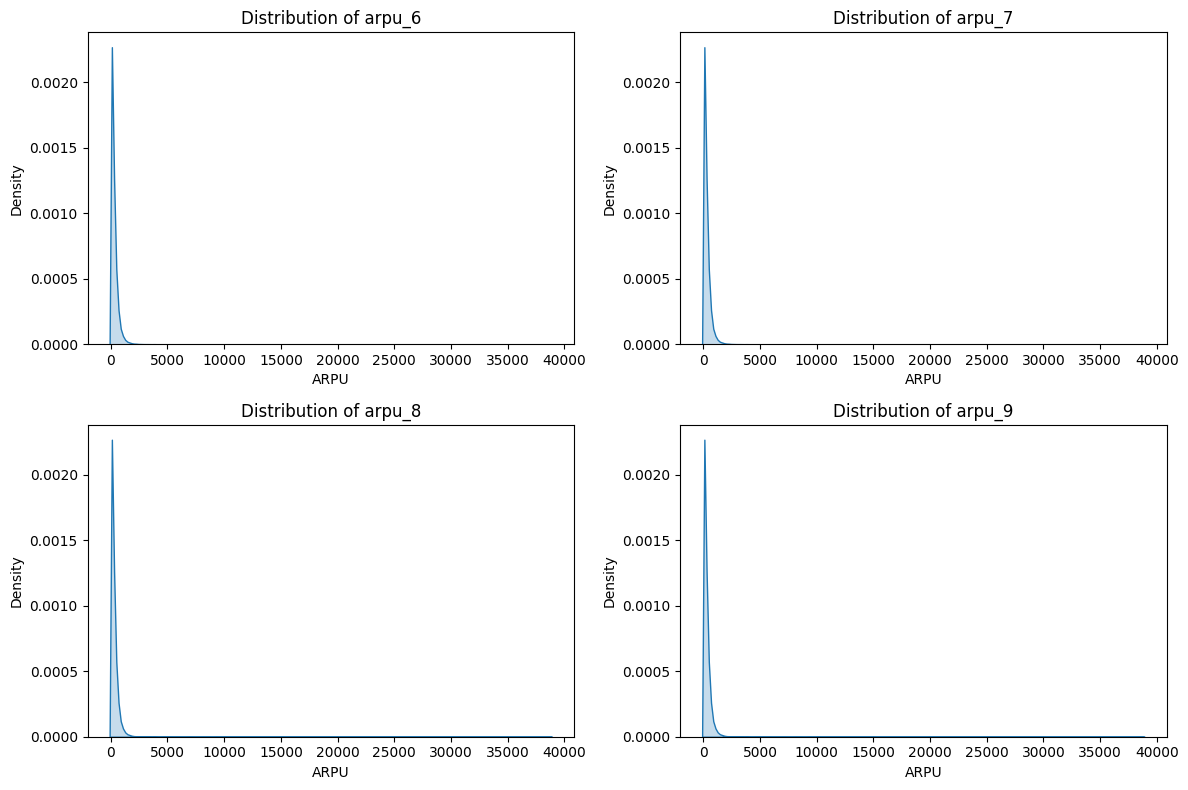

In [17]:
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(12,8))

arpu_columns = ['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9']
for i, columns in enumerate(arpu_columns):
    sns.kdeplot(dataframe[col], ax=axs[i//2, i%2], shade=True)
    axs[i//2, i%2].set_title(f'Distribution of {columns}')
    axs[i//2, i%2].set_xlabel('ARPU')

plt.tight_layout()
plt.show()

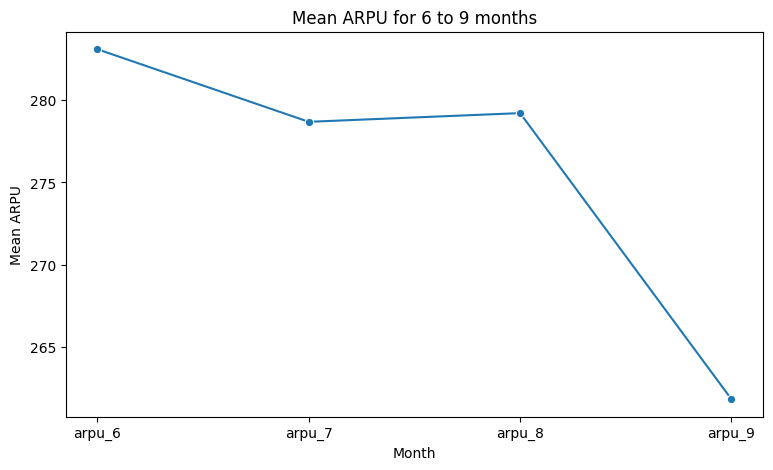

In [18]:
arpu_means = dataframe[arpu_columns].mean()

plt.figure(figsize=(9,5))
sns.lineplot(x=arpu_columns, y=arpu_means.values, marker='o')
plt.title('Mean ARPU for 6 to 9 months')
plt.xlabel('Month')
plt.ylabel('Mean ARPU')
plt.show()


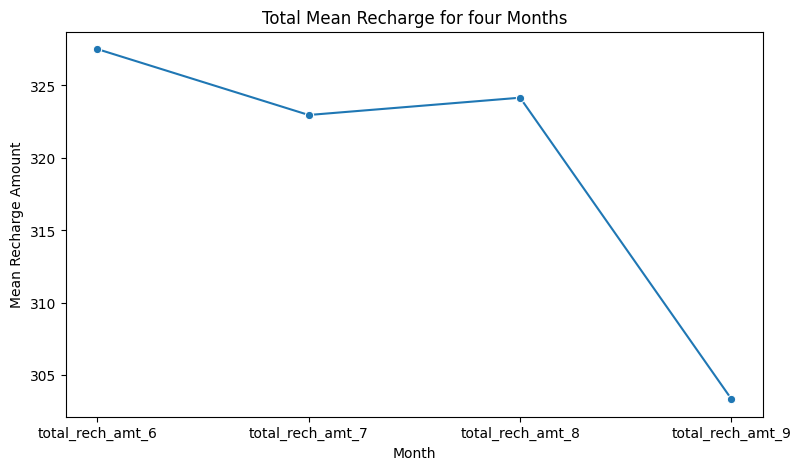

In [19]:
recharge_cols = ['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9']

rechagre_means = dataframe[recharge_cols].mean()

plt.figure(figsize=(9,5))
sns.lineplot(x=recharge_cols, y=rechagre_means.values, marker='o')
plt.title('Total Mean Recharge for four Months')
plt.xlabel('Month')
plt.ylabel('Mean Recharge Amount')
plt.show()


In [20]:
dataframe['churn'] = dataframe['total_rech_amt_9'].apply(lambda x: 1 if x == 0 else 0)


In [21]:
print(dataframe['churn'].value_counts(normalize=True))

churn
0    0.820438
1    0.179562
Name: proportion, dtype: float64


In [22]:
dataframe[dataframe['churn'] == 1].head(20)

,mobile_number,circle_id,arpu_6,arpu_7,arpu_8,arpu_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn
0,7000842753,109,197.385,214.816,213.803,21.10,0.00,0.00,0.00,0.00,...,1.0,1.0,1.0,0.0,968,30.40,0.00,101.20,3.58,1
7,7000701601,109,1069.180,1349.850,3171.480,500.00,16.23,33.49,31.64,0.00,...,0.0,0.0,0.0,0.0,802,57.74,19.38,18.74,0.00,1
11,7002006969,109,298.126,21.000,131.617,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,1.0,0.0,339,0.00,0.00,0.00,0.00,1
22,7001121249,109,281.076,26.291,0.000,0.30,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,396,0.00,0.00,0.00,0.00,1
28,7001604038,109,117.392,85.967,109.042,36.90,0.00,0.00,0.00,0.00,...,0.0,0.0,1.0,0.0,502,0.36,0.00,0.00,0.00,1
29,7000039512,109,147.460,22.460,0.000,0.10,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,263,0.00,0.00,0.00,0.00,1
32,7000382876,109,60.651,22.064,52.380,0.00,0.00,0.00,0.00,0.00,...,1.0,1.0,0.0,0.0,229,0.00,0.00,0.00,0.00,1
35,7002108620,109,596.376,13.448,0.000,0.00,196.49,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,2036,0.00,0.00,0.00,0.00,1
45,7002388962,109,247.064,7.500,0.000,0.00,25.48,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,740,0.00,0.00,0.00,0.00,1
47,7001482006,109,31.180,72.510,32.660,94.57,0.00,0.00,0.00,0.00,...,1.0,0.0,0.0,1.0,3105,484.63,355.68,378.77,48.51,1


Sequence Preparation and Feature Selection

In [23]:

months = ['_6', '_7', '_8']
X = dataframe[[col for col in dataframe.columns if any(m in col for m in months)]]
y = dataframe['churn'].values

monthlist = ['_6', '_7', '_8']
sequence_feature = sorted(set([col[:-2] for col in X.columns]))

seq = []
for _, row in dataframe.iterrows():
    user_sequence = []
    for m in monthlist:
        variables = [row[feat + m] for feat in sequence_feature]
        user_sequence.append(variables)
    seq.append(user_sequence)

X_sequence = np.array(seq)

n_samples, n_timesteps, n_features = X_sequence.shape
scaler = StandardScaler()
X_sequence = scaler.fit_transform(X_sequence.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)

Train and Validation split

In [24]:
from sklearn.utils import class_weight

X_train, X_val, y_train, y_val = train_test_split(X_sequence, y, test_size=0.2, random_state=42, stratify=y)

weight = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = {i: weight[i] for i in range(len(weight))}


LSTM without Attention

In [49]:
lstm_model_1 = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.3, recurrent_dropout=0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = lstm_model_1.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    callbacks=[early_stop]
)
y_probs = lstm_model_1.predict(X_val).flatten()


precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

best_thresh = 0.5
for t, r in zip(thresholds, recall):
    if r >= 0.75:
        best_thresh = t
        break

print(f"Best threshold for Recall ≥ 75%: {best_thresh:.3f}")


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6759 - loss: 0.5788 - val_accuracy: 0.8122 - val_loss: 0.4412
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7570 - loss: 0.5153 - val_accuracy: 0.7408 - val_loss: 0.5057
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7641 - loss: 0.4939 - val_accuracy: 0.7894 - val_loss: 0.4580
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7724 - loss: 0.4987 - val_accuracy: 0.7921 - val_loss: 0.4565
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7713 - loss: 0.4940 - val_accuracy: 0.8099 - val_loss: 0.4286
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7807 - loss: 0.4836 - val_accuracy: 0.7940 - val_loss: 0.4566
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7801 - loss: 0.4841 - val_accuracy: 0.8213 - val_loss: 0.4189
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7796 - loss: 0.4841 - val_

In [50]:
y_pred = (y_probs >= 0.5).astype(int)

print("Confusion Matrix for LSTM without Attention:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report for LSTM without Attention:")
print(classification_report(y_val, y_pred, digits=4))


Confusion Matrix for LSTM without Attention:
[[14892  1517]
 [ 1461  2130]]

Classification Report for LSTM without Attention:
              precision    recall  f1-score   support

           0     0.9107    0.9076    0.9091     16409
           1     0.5840    0.5931    0.5886      3591

    accuracy                         0.8511     20000
   macro avg     0.7474    0.7504    0.7488     20000
weighted avg     0.8520    0.8511    0.8515     20000



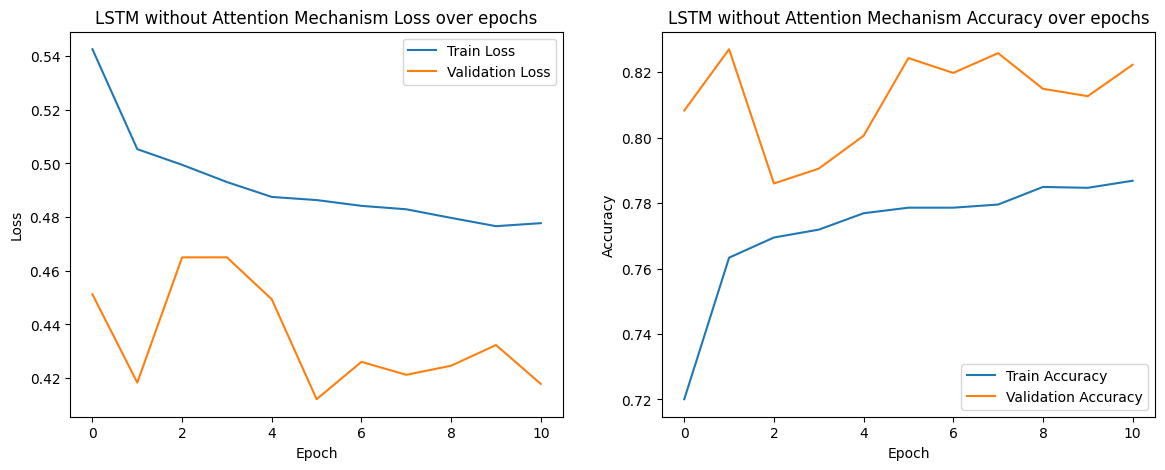

In [59]:
import matplotlib.pyplot as plt

def plot_training_curves(history, model_name="LSTM without Attention Mechanism"):
    plt.figure(figsize=(14,5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_curves(history, model_name="LSTM without Attention Mechanism")


LSTM with Attention

In [52]:
from tensorflow.keras.layers import Input, LSTM, Dense, Layer
from tensorflow.keras.models import Model
import tensorflow as tf

class AttentionWithWeights(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionWithWeights, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="random_normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionWithWeights, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weight = tf.nn.softmax(score, axis=1)
        vector = attention_weight * inputs
        vector = tf.reduce_sum(vector, axis=1)
        return vector, tf.squeeze(attention_weight, -1)

inputs = tf.keras.Input(shape=(X_sequence.shape[1], X_sequence.shape[2]))
lstm_out = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
attention_out, attention_weight = AttentionWithWeights()(lstm_out)
output = tf.keras.layers.Dense(1, activation='sigmoid')(attention_out)

attention_model = tf.keras.Model(inputs=inputs, outputs=[output, attention_weight])
attention_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
from tensorflow.keras.models import Sequential

lstm_model_2 = Sequential([
    LSTM(64, input_shape=(X_sequence.shape[1], X_sequence.shape[2]), dropout=0.3, recurrent_dropout=0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model_2.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    callbacks=[early_stop]
)


Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6538 - loss: 0.5764 - val_accuracy: 0.8083 - val_loss: 0.4512
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7605 - loss: 0.5100 - val_accuracy: 0.8270 - val_loss: 0.4183
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7706 - loss: 0.5013 - val_accuracy: 0.7860 - val_loss: 0.4650
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7733 - loss: 0.4959 - val_accuracy: 0.7905 - val_loss: 0.4650
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7771 - loss: 0.4903 - val_accuracy: 0.8006 - val_loss: 0.4494
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7784 - loss: 0.4890 - val_accuracy: 0.8243 - val_loss: 0.4121
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7816 - loss: 0.4826 - val_accuracy: 0.8198 - val_loss: 0.4261
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7766 - loss: 0

In [55]:
y_probs = lstm_model_2.predict(X_val).flatten()

precision, recall, thresholds = precision_recall_curve(y_val, y_probs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [56]:
best_threshold=0.5
y_pred = (y_probs >= best_threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix with Attention:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report with Attention:")
print(classification_report(y_val, y_pred))


Confusion Matrix with Attention:
[[13865  2544]
 [  969  2622]]

Classification Report with Attention:
              precision    recall  f1-score   support

           0       0.93      0.84      0.89     16409
           1       0.51      0.73      0.60      3591

    accuracy                           0.82     20000
   macro avg       0.72      0.79      0.74     20000
weighted avg       0.86      0.82      0.84     20000



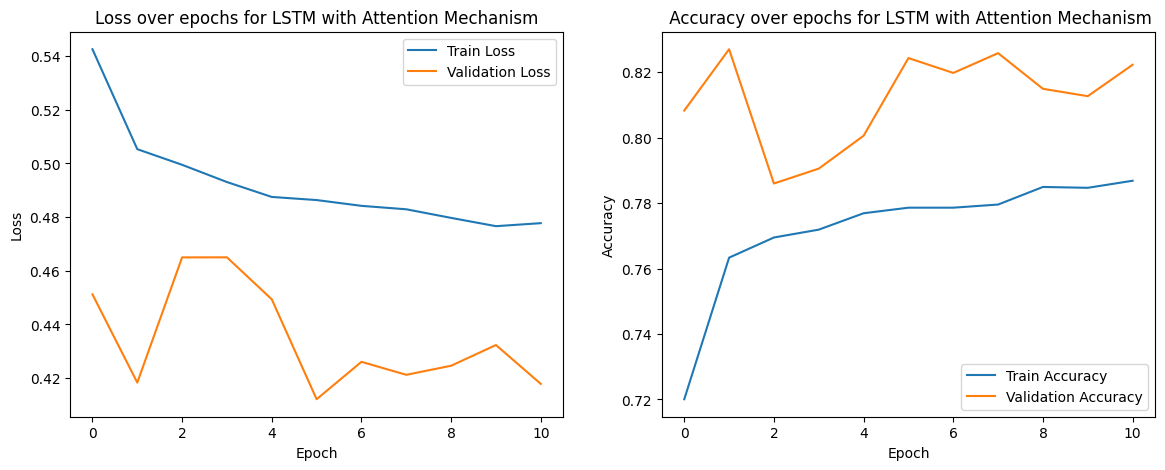

In [58]:
import matplotlib.pyplot as plt

def plot_training_curves(history, model_name="LSTM with Attention Mechanism"):
    plt.figure(figsize=(14,5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss over epochs for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f' Accuracy over epochs for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_curves(history, model_name="LSTM with Attention Mechanism")


GraphSAGE Model

In [38]:
import torch
from torch_geometric.data import Data

num_nodes = 1000
num_features = 24
num_edges = 5000

X_flat = torch.randn(num_nodes, num_features)

edge_index = torch.randint(0, num_nodes, (2, num_edges))

y = torch.randint(0, 2, (num_nodes,))

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[:800] = True
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[800:] = True


In [39]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import SAGEConv
import matplotlib.pyplot as plt


In [40]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = Data(x=X_flat.to(device), edge_index=edge_index.to(device), y=y.to(device))
data.train_mask = train_mask.to(device)
data.test_mask = test_mask.to(device)


In [41]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [42]:
model = GraphSAGE(data.num_node_features, 64, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.004)
criterion = torch.nn.CrossEntropyLoss()

train_loader = NeighborLoader(
    data,
    num_neighbors=[10, 5],
    batch_size=512,
    input_nodes=data.train_mask
)

test_loader = NeighborLoader(
    data,
    num_neighbors=[10, 5],
    batch_size=1024,
    input_nodes=data.test_mask
)


/usr/local/lib/python3.12/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [43]:
def calc_metrics(y_true, y_pred):
    TP = ((y_pred == 1) & (y_true == 1)).sum()
    TN = ((y_pred == 0) & (y_true == 0)).sum()
    FP = ((y_pred == 1) & (y_true == 0)).sum()
    FN = ((y_pred == 0) & (y_true == 1)).sum()

    precision = TP.float() / (TP + FP + 1e-8)
    recall = TP.float() / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    accuracy = (TP + TN).float() / (TP + TN + FP + FN + 1e-8)

    return accuracy.item(), precision.item(), recall.item(), f1.item()


In [44]:
def train_epoch():
    model.train()
    total_loss = 0
    total_nodes = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_nodes
        total_nodes += batch.num_nodes
    return total_loss / total_nodes


def evaluate(loader, return_preds=False):
    model.eval()
    all_preds, all_labels = [], []
    total_loss, total_nodes = 0, 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            loss = criterion(out, batch.y)
            total_loss += loss.item() * batch.num_nodes
            total_nodes += batch.num_nodes

            preds = out.argmax(dim=1)
            all_preds.append(preds)
            all_labels.append(batch.y)

    y_pred = torch.cat(all_preds)
    y_true = torch.cat(all_labels)
    avg_loss = total_loss / total_nodes
    acc, prec, rec, f1 = calc_metrics(y_true, y_pred)

    if return_preds:
        return avg_loss, acc, prec, rec, f1, y_pred, y_true
    else:
        return avg_loss, acc, prec, rec, f1


In [45]:
epochs = 30
train_losses, test_losses = [], []
test_accuracies, test_precisions, test_recalls, test_f1s = [], [], [], []

for epoch in range(epochs):
    train_loss = train_epoch()
    test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate(test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    test_precisions.append(test_prec)
    test_recalls.append(test_rec)
    test_f1s.append(test_f1)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f} | Test Loss {test_loss:.4f} | "
          f"Test Acc {test_acc:.4f} | Precision {test_prec:.4f} | Recall {test_rec:.4f} | F1 {test_f1:.4f}")


Epoch 1: Train Loss 0.7065 | Test Loss 0.6917 | Test Acc 0.5404 | Precision 0.5294 | Recall 0.2009 | F1 0.2913
Epoch 2: Train Loss 0.6910 | Test Loss 0.6816 | Test Acc 0.5534 | Precision 0.5804 | Recall 0.1865 | F1 0.2823
Epoch 3: Train Loss 0.6764 | Test Loss 0.6695 | Test Acc 0.5839 | Precision 0.5911 | Recall 0.3822 | F1 0.4642
Epoch 4: Train Loss 0.6621 | Test Loss 0.6632 | Test Acc 0.5968 | Precision 0.5740 | Recall 0.5702 | F1 0.5721
Epoch 5: Train Loss 0.6557 | Test Loss 0.6546 | Test Acc 0.6070 | Precision 0.5862 | Recall 0.5692 | F1 0.5776
Epoch 6: Train Loss 0.6443 | Test Loss 0.6481 | Test Acc 0.6128 | Precision 0.6132 | Recall 0.4777 | F1 0.5370
Epoch 7: Train Loss 0.6346 | Test Loss 0.6416 | Test Acc 0.6326 | Precision 0.6644 | Recall 0.4400 | F1 0.5294
Epoch 8: Train Loss 0.6273 | Test Loss 0.6378 | Test Acc 0.6359 | Precision 0.6667 | Recall 0.4439 | F1 0.5330
Epoch 9: Train Loss 0.6183 | Test Loss 0.6291 | Test Acc 0.6450 | Precision 0.6687 | Recall 0.4933 | F1 0.5678
E

In [46]:
test_loss, test_acc, test_prec, test_rec, test_f1, y_pred, y_true = evaluate(test_loader, return_preds=True)

def manual_classification_report(y_true, y_pred, labels=[0,1]):
    report = {}
    for label in labels:
        TP = ((y_pred == label) & (y_true == label)).sum().item()
        FP = ((y_pred == label) & (y_true != label)).sum().item()
        FN = ((y_pred != label) & (y_true == label)).sum().item()
        TN = ((y_pred != label) & (y_true != label)).sum().item()

        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        support = (y_true == label).sum().item()

        report[label] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1,
            'support': support
        }

    accuracy = (y_pred == y_true).sum().item() / y_true.size(0)

    print("Classification Report (manual PyTorch):\n")
    print(f"{'Label':<10}{'Precision':>10}{'Recall':>10}{'F1-Score':>10}{'Support':>10}")
    for label in labels:
        p = report[label]['precision']
        r = report[label]['recall']
        f1 = report[label]['f1-score']
        sup = report[label]['support']
        print(f"{label:<10}{p:10.4f}{r:10.4f}{f1:10.4f}{sup:10d}")
    print(f"\n{'Accuracy':<10}{accuracy:.4f}")

manual_classification_report(y_true, y_pred)


Classification Report (manual PyTorch):

Label      Precision    Recall  F1-Score   Support
0             0.8441    0.8775    0.8605       506
1             0.8551    0.8170    0.8356       448

Accuracy  0.8491


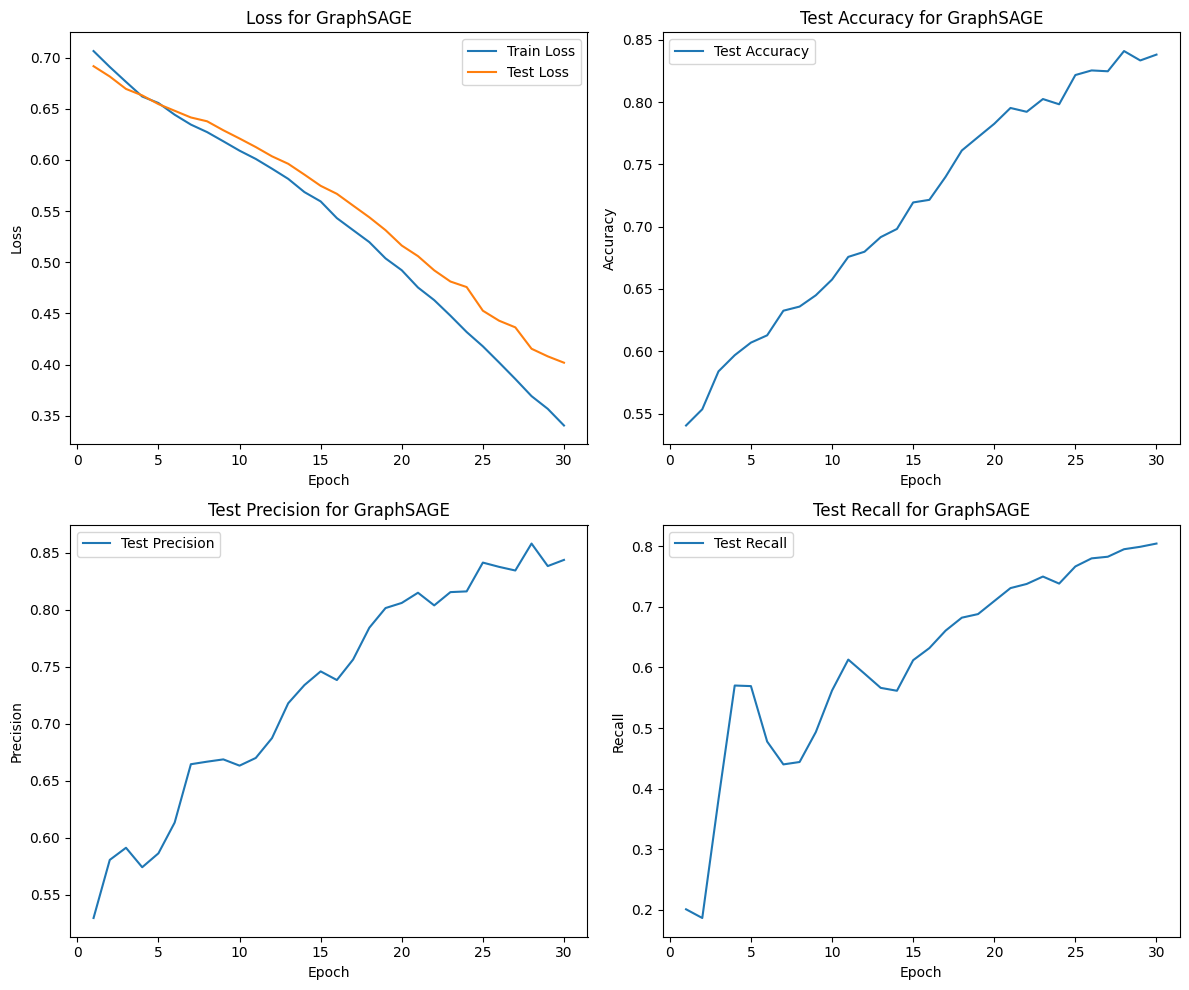

In [47]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for GraphSAGE')
plt.legend()

plt.subplot(2,2,2)
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for GraphSAGE')
plt.legend()

plt.subplot(2,2,3)
plt.plot(range(1, epochs+1), test_precisions, label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Test Precision for GraphSAGE')
plt.legend()

plt.subplot(2,2,4)
plt.plot(range(1, epochs+1), test_recalls, label='Test Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Test Recall for GraphSAGE')
plt.legend()

plt.tight_layout()
plt.show()



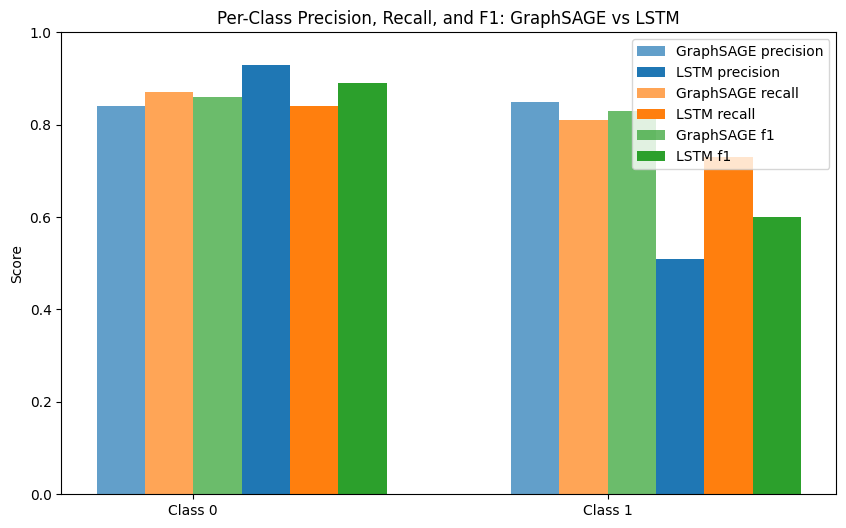

In [60]:
import matplotlib.pyplot as plt

# Sample per-class metrics (replace with your real results)
graphsage_metrics = {
    0: {'precision': 0.84, 'recall': 0.87, 'f1': 0.86},
    1: {'precision': 0.85, 'recall': 0.81, 'f1': 0.83}
}

lstm_metrics = {
    0: {'precision': 0.93, 'recall': 0.84, 'f1': 0.89},
    1: {'precision': 0.51, 'recall': 0.73, 'f1': 0.60}
}
classes = [0, 1]
metrics = ['precision', 'recall', 'f1']
colors = {'precision': 'tab:blue', 'recall': 'tab:orange', 'f1': 'tab:green'}

bar_width = 0.35
x = range(len(classes))

fig, ax = plt.subplots(figsize=(10,6))

for i, metric in enumerate(metrics):
    # Positions for GraphSAGE bars
    gs_positions = [pos - bar_width/2 + i*(bar_width/len(metrics)) for pos in x]
    gs_values = [graphsage_metrics[c][metric] for c in classes]
    ax.bar(gs_positions, gs_values, bar_width/len(metrics), label=f'GraphSAGE {metric}', color=colors[metric], alpha=0.7)

    # Positions for LSTM bars (shift right)
    lstm_positions = [pos + bar_width/2 + i*(bar_width/len(metrics)) for pos in x]
    lstm_values = [lstm_metrics[c][metric] for c in classes]
    ax.bar(lstm_positions, lstm_values, bar_width/len(metrics), label=f'LSTM {metric}', color=colors[metric])

ax.set_xticks(x)
ax.set_xticklabels([f'Class {c}' for c in classes])
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Per-Class Precision, Recall, and F1: GraphSAGE vs LSTM')
ax.legend(loc='upper right')

plt.show()
